# Analysis of Metallurgical Grain Properties
**Project:** Metallurgical Image Analysis

**Author:** Simon Mejia Zuluaga

**Date:** June 17, 2025

## Objective
This notebook analyzes the grain properties extracted from three different metal sample types: X-6, X-19, and X-28. The goal is to identify and quantify any significant differences in their microstructures by comparing key features like grain area, solidity, and eccentricity.

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import scikit_posthocs as sp

sns.set_theme(style="whitegrid", palette="viridis")
%matplotlib inline

## 1. Data Loading
The first step is to locate all the processed `.csv` files generated by the `analyze_grains.py` script.`glob` library was used to find all files matching the path pattern and then load them into a single, master `pandas` DataFrame. A `sample_type` column was added to identify the source of each measurement.

In [3]:
path_pattern = 'data/**/*.csv'
all_files = glob.glob(path_pattern, recursive=True)

# Create a list to hold the individual dataframes
li = []

for filename in all_files:
    # Read the csv file
    df = pd.read_csv(filename, index_col=None, header=0)
    
    # Extract the sample type (e.g., 'X-6') from the directory path
    sample_type = os.path.basename(os.path.dirname(filename))
    df['sample_type'] = sample_type
    
    li.append(df)

# Concatenate all dataframes into a single master dataframe
master_df = pd.concat(li, axis=0, ignore_index=True)

print(f"Successfully loaded {len(master_df)} total grains from {len(all_files)} files.")
print("\nDataFrame Info:")
master_df.info()

print("\nFirst 5 rows of the master dataset:")
master_df.head()

Successfully loaded 502 total grains from 17 files.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   area                 502 non-null    float64
 1   perimeter            502 non-null    float64
 2   eccentricity         502 non-null    float64
 3   solidity             502 non-null    float64
 4   equivalent_diameter  502 non-null    float64
 5   orientation          502 non-null    float64
 6   major_axis_length    502 non-null    float64
 7   minor_axis_length    502 non-null    float64
 8   sample_type          502 non-null    object 
dtypes: float64(8), object(1)
memory usage: 35.4+ KB

First 5 rows of the master dataset:


,area,perimeter,eccentricity,solidity,equivalent_diameter,orientation,major_axis_length,minor_axis_length,sample_type
0,2150.0,240.568542,0.932951,0.958538,52.320790,-0.230819,94.623250,34.064659,X-28
1,1209445.0,14120.278564,0.898291,0.938392,1240.932392,0.281254,2048.205811,899.985347,X-28
2,3382816.0,37176.973465,0.637928,0.909754,2075.363849,0.850859,2528.969074,1947.549901,X-28
3,3222.0,300.124892,0.931956,0.931214,64.049807,1.319718,117.639081,42.652647,X-28
4,2518.0,344.048773,0.757337,0.705322,56.621702,0.257938,82.892495,54.130796,X-28


## 2. EDA
With the data loaded, initial exploration was performed to understand its characteristics. High-level statistical summary and visualizations were created to compare the distributions of key features across the different sample types.

In [4]:
display_cols = ['area', 'solidity', 'eccentricity', 'major_axis_length']
summary_stats = master_df.groupby('sample_type')[display_cols].describe()

print("Summary Statistics by Sample Type:")
summary_stats

Summary Statistics by Sample Type:


area                                                       \
             count           mean           std     min     25%     50%   
sample_type                                                               
X-19          67.0   84322.298507  3.403274e+05  2011.0  3817.0  8730.0   
X-28          29.0  617255.241379  1.413741e+06  2150.0  3222.0  5285.0   
X-6          406.0   81212.667488  3.892822e+05  2004.0  3066.0  6183.5   

                                 solidity            ... eccentricity  \
                  75%        max    count      mean  ...          75%   
sample_type                                          ...                
X-19         16923.00  2364863.0     67.0  0.739902  ...     0.895136   
X-28         73972.00  4463832.0     29.0  0.855189  ...     0.957082   
X-6          17982.75  3376358.0    406.0  0.755245  ...     0.902695   

                      major_axis_length                                     \
                  max             count        mean         std        min   
sample_type                                                                  
X-19         0.983273              67.0  316.480581  562.266250  66.728248   
X-28         0.999046              29.0  665.662110  967.925222  82.892495   
X-6          0.985441             406.0  282.530185  462.164366  64.278830   

                                                              
                    25%         50%         75%          max  
sample_type                                                   
X-19         103.934090  159.073828  245.941964  2924.311241  
X-28         117.639081  148.812934  683.122188  2956.362962  
X-6           96.797548  145.363392  242.857325  2991.484406  

[3 rows x 32 columns]

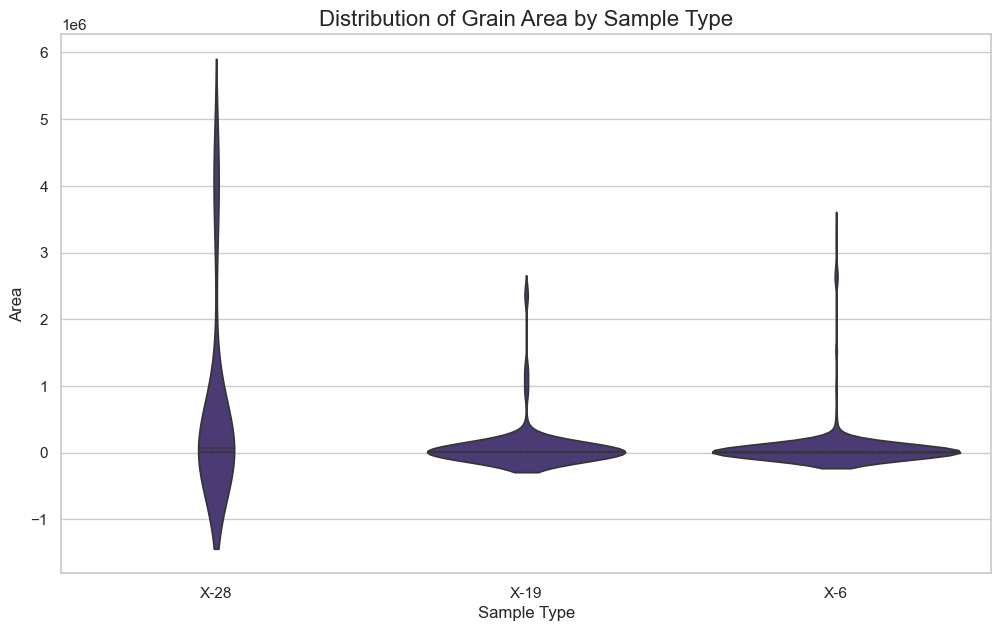

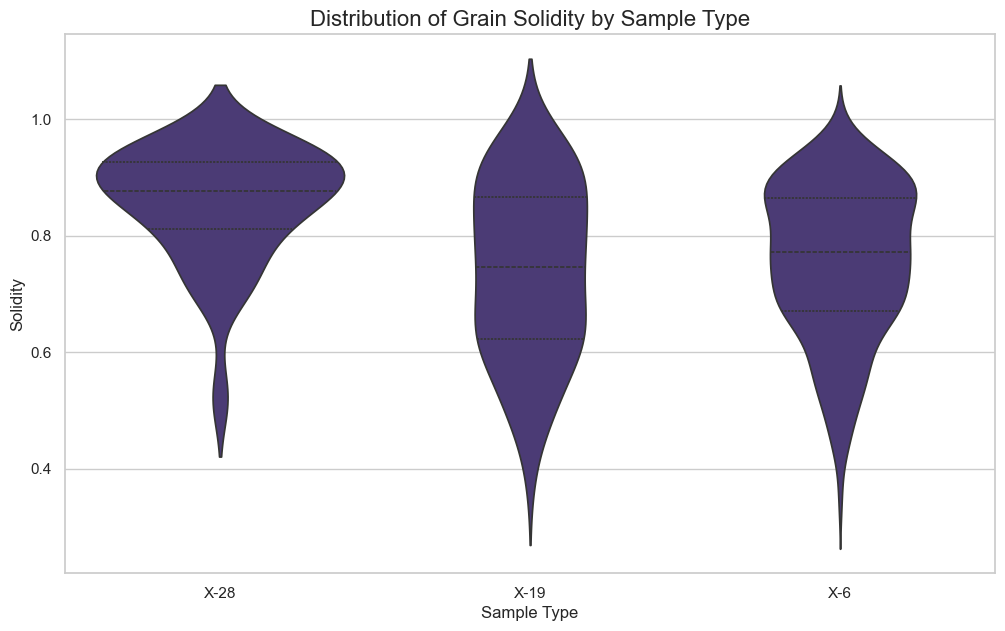

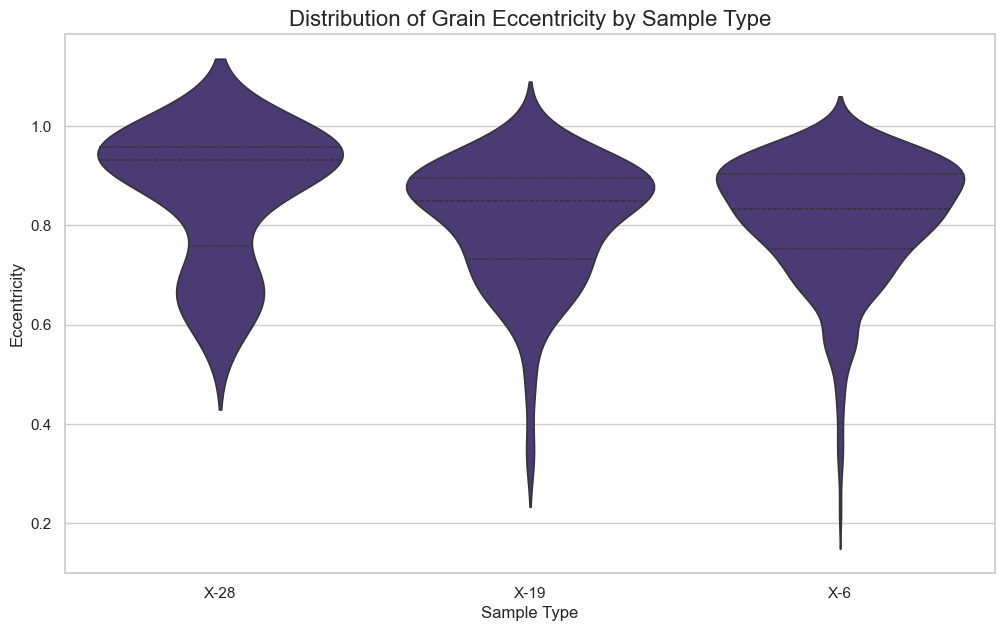

In [5]:
# Use a loop to generate violin plots for our key features
features_to_plot = ['area', 'solidity', 'eccentricity']

for feature in features_to_plot:
    plt.figure(figsize=(12, 7))
    sns.violinplot(x='sample_type', y=feature, data=master_df, inner='quartile')
    plt.title(f'Distribution of Grain {feature.capitalize()} by Sample Type', fontsize=16)
    plt.xlabel('Sample Type', fontsize=12)
    plt.ylabel(f'{feature.capitalize()}', fontsize=12)
    
    # --- Save the Plot ---
    # Create the directory if it doesn't exist
    os.makedirs('output/final_plots', exist_ok=True)
    plt.savefig(f'output/final_plots/{feature}_distribution_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.show()

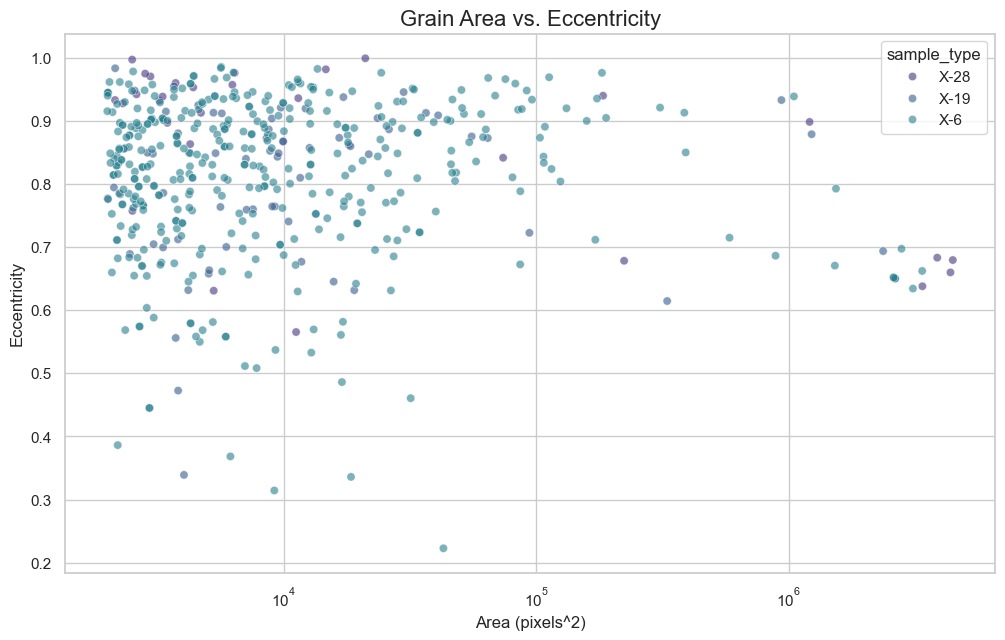

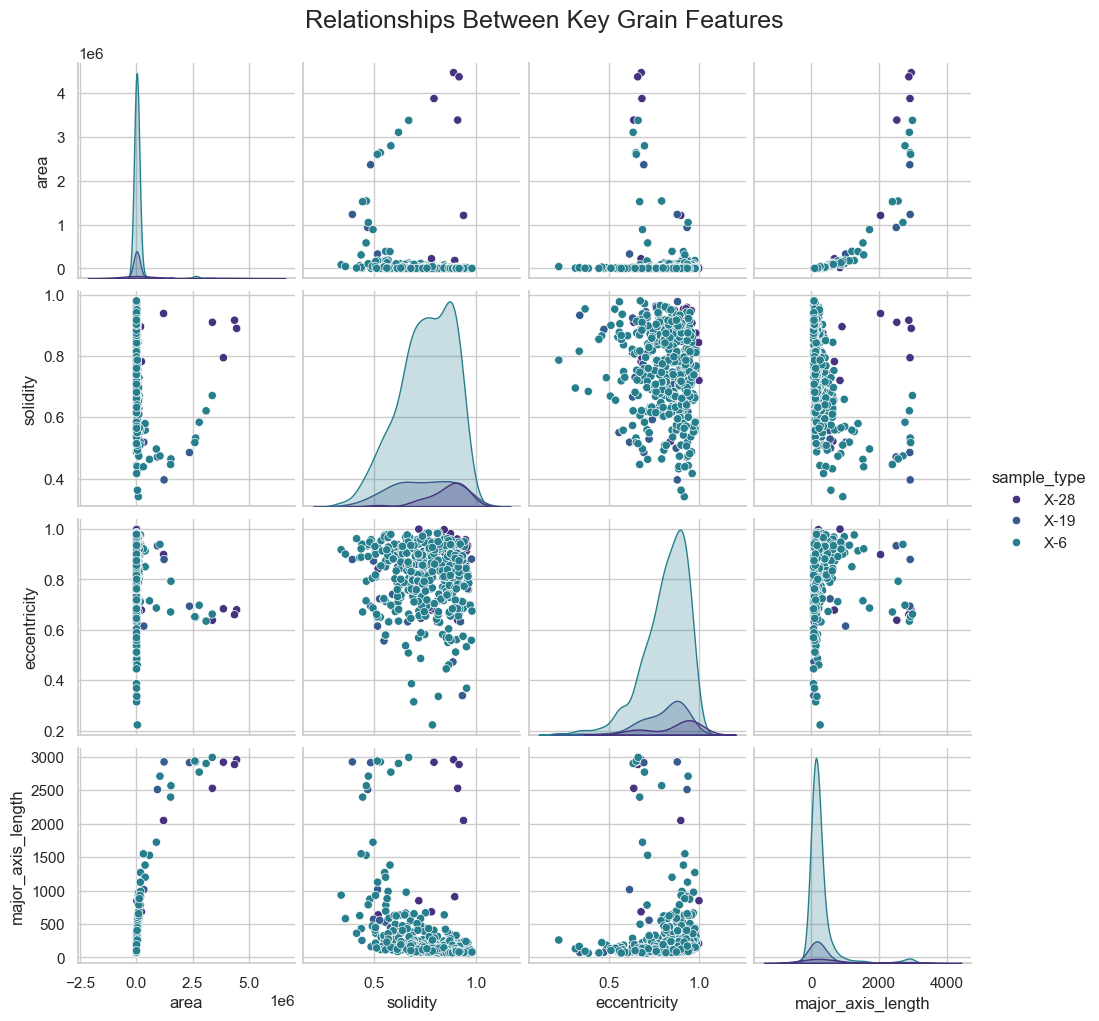

In [6]:
# Scatter plot to check the relationship between area and eccentricity
plt.figure(figsize=(12, 7))
sns.scatterplot(data=master_df, x='area', y='eccentricity', hue='sample_type', alpha=0.6)
plt.title('Grain Area vs. Eccentricity', fontsize=16)
plt.xlabel('Area (pixels^2)', fontsize=12)
plt.ylabel('Eccentricity', fontsize=12)
plt.xscale('log') # Use a log scale
plt.show()

# Pair Plot for a high-level overview (VERY SLOW! Comment out if not wanted or not the first time running)
pairplot_cols = ['area', 'solidity', 'eccentricity', 'major_axis_length', 'sample_type']
pairplot_fig = sns.pairplot(master_df[pairplot_cols], hue='sample_type', height=2.5)
pairplot_fig.fig.suptitle('Relationships Between Key Grain Features', y=1.02, fontsize=18)
plt.savefig('output/final_plots/feature_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Statistical Hypothesis Testing
While visualizations suggest differences, formal statistical tests can quantify whether these differences are significant. We will use an **Analysis of Variance (ANOVA)** test to check if there's a significant difference in a feature's mean across the three sample groups. If the result is significant (p-value < 0.05), we will perform a **Dunn's post-hoc test** to identify which specific pairs of samples are different from each other.

### 3.1. Test for: Grain Area

One-way ANOVA P-value: 0.000000
Result is statistically significant. There is a difference between the groups.
Running Dunn's post-hoc test...


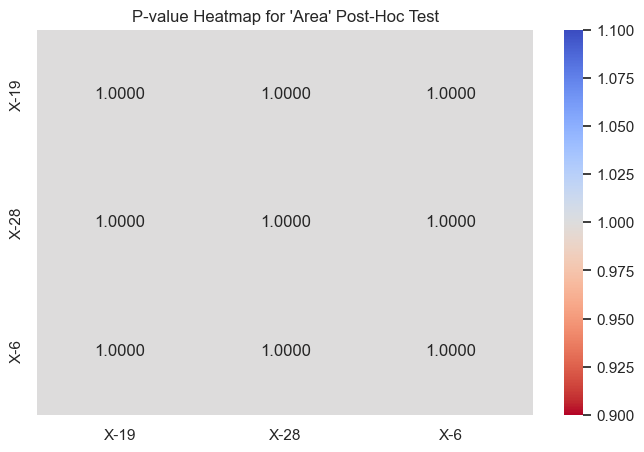

In [7]:
# --- Statistical Test for area ---
feature_to_test = 'area'

# Create a list of the 'area' data for each sample type
grouped_data_area = [group[feature_to_test].values for name, group in master_df.groupby('sample_type')]

# Perform the one-way ANOVA test
f_stat_area, p_value_area = f_oneway(*grouped_data_area)

print(f"One-way ANOVA P-value: {p_value_area:.6f}")

# Interpret the result and run post-hoc if needed
if p_value_area < 0.05:
    print("Result is statistically significant. There is a difference between the groups.")
    print("Running Dunn's post-hoc test...")
    posthoc_results_area = sp.posthoc_dunn(master_df, val_col=feature_to_test, group_col='sample_type', p_adjust='bonferroni')
    
    plt.figure(figsize=(8, 5))
    sns.heatmap(posthoc_results_area, annot=True, cmap='coolwarm_r', fmt='.4f')
    plt.title(f"P-value Heatmap for '{feature_to_test.capitalize()}' Post-Hoc Test")
    plt.show()
else:
    print("Result is not statistically significant.")

### 3.2. Test for: Grain Eccentricity

In [8]:
# --- Statistical Test for eccentricity ---
feature_to_test = 'eccentricity'

# Create a list of the 'eccentricity' data for each sample type
grouped_data_ecc = [group[feature_to_test].values for name, group in master_df.groupby('sample_type')]

# Perform the one-way ANOVA test
f_stat_ecc, p_value_ecc = f_oneway(*grouped_data_ecc)

print(f"--- Statistical Test for '{feature_to_test.capitalize()}' ---")
print(f"One-way ANOVA P-value: {p_value_ecc:.6f}")

# Interpret the result and run post-hoc if necessary
if p_value_ecc < 0.05:
    print("Result is statistically significant. There is a difference between the groups.")
    print("Running Dunn's post-hoc test...")
    posthoc_results_ecc = sp.posthoc_dunn(master_df, val_col=feature_to_test, group_col='sample_type', p_adjust='bonferroni')
    
    plt.figure(figsize=(8, 5))
    sns.heatmap(posthoc_results_ecc, annot=True, cmap='coolwarm_r', fmt='.4f')
    plt.title(f"P-value Heatmap for '{feature_to_test.capitalize()}' Post-Hoc Test")
    plt.show()
else:
    print("Result is not statistically significant.")

--- Statistical Test for 'Eccentricity' ---
One-way ANOVA P-value: 0.099458
Result is not statistically significant.
